<a href="https://colab.research.google.com/github/AvellinaLeong/NHM-Nannofossil-Segmentation-Project/blob/main/03b_Binary_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary Classification Model



*   After cropping and padding segmentations, have to manually sort into 0 (nannofossil) and 1 (non nannofossil)



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Set script location to own development space
MY_DEVELOPMENT_SPACE = '/content/drive/MyDrive/development/avellina/'
import os
os.chdir(MY_DEVELOPMENT_SPACE)
!pwd
!ls

Mounted at /content/drive/
/content/drive/MyDrive/development/avellina
Binary_Classification_notebooks  Detectron2_notebooks  Morphometrics_notebooks	src
detectron2			 Mask-RCNN	       output


## Make CSV for test set

In [ ]:
import os
import pandas as pd

# Define the paths to the test images directories
test_nannofossil_path = '/content/drive/MyDrive/data/species_53/Binary_Classification/1_test_nannofossil/'
test_not_nannofossil_path = '/content/drive/MyDrive/data/species_53/Binary_Classification/0_test_not_nannofossil/'

# Get a list of all image filenames in the test directories
nannofossil_images = [f for f in os.listdir(test_nannofossil_path) if os.path.isfile(os.path.join(test_nannofossil_path, f))]
not_nannofossil_images = [f for f in os.listdir(test_not_nannofossil_path) if os.path.isfile(os.path.join(test_not_nannofossil_path, f))]

# Create DataFrames for each class
nannofossil_df = pd.DataFrame(nannofossil_images, columns=['image_name'])
nannofossil_df['binary_classification'] = 1

not_nannofossil_df = pd.DataFrame(not_nannofossil_images, columns=['image_name'])
not_nannofossil_df['binary_classification'] = 0

# Combine the DataFrames
test_df = pd.concat([nannofossil_df, not_nannofossil_df], ignore_index=True)

# Define the output path for the CSV file
dataframe_output_path = '/content/drive/MyDrive/data/species_53/Binary_Classification/test_binary_data_input.csv'

# Save the DataFrame to a CSV file
test_df.to_csv(dataframe_output_path, index=False)

print(f"CSV file created at: {dataframe_output_path}")

KeyboardInterrupt: 

In [ ]:
# Count the number of 0s and 1s in the binary_classification column
class_counts = test_df['binary_classification'].value_counts()
print(f"Number of 0s: {class_counts[0]}")
print(f"Number of 1s: {class_counts[1]}")

Number of 0s: 145
Number of 1s: 110


## Load Dependencies

In [ ]:
import numpy as np
import pandas as pd
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
from scipy import ndimage
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from PIL import Image
import imgaug.augmenters as iaa
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, model_from_json, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import RandomCrop, CenterCrop, RandomRotation
from tensorflow.keras.optimizers.schedules import CosineDecay


In [ ]:
# Utilitiy files located in the src folder
from src.data_util import check_corrupted, find_binary_class_weights, define_classes
from src.plot_util import show_one_image, show_augmentation_layers, plot_learning_curve
from src.plot_util import plot_confusion_matrix, plot_roc_curve
from src.plot_util import test_image, display_right_prediction, display_wrong_prediction
from src.model_util import train_val_test_split, load_image_and_label_from_path
from src.model_util import get_data_augmentation_layers_keras, get_imgaug_augmentation
from src.model_util import create_model_enb1

## Prepare Data

In [ ]:
#path to the dataset folder
data_folder_path = '/content/drive/MyDrive/data/species_53/Binary_Classification'
#import the csv file with val and train
sample_df = pd.read_csv(data_folder_path + "/binary_classification_dataframe.csv")

In [ ]:
# Load the test CSV file as test_df
test_df = pd.read_csv('/content/drive/MyDrive/data/species_53/Binary_Classification/test_binary_data_input.csv')

In [ ]:
# Combine the two dataframes to make an overall one
sample_df_path = data_folder_path + "/binary_classification_dataframe.csv"
test_df_path = '/content/drive/MyDrive/data/species_53/Binary_Classification/test_binary_data_input.csv'
output_path = '/content/drive/MyDrive/data/species_53/Binary_Classification/all_binary_classification_dataframe.csv'

# Read the dataframes
sample_df = pd.read_csv(sample_df_path)
test_df = pd.read_csv(test_df_path)

# Add a new column indicating the source
sample_df['source'] = 'test_val'
test_df['source'] = 'test'

# Concatenate the dataframes
combined_df = pd.concat([sample_df, test_df], axis=0, ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv(output_path, index=False)

print(f"Combined dataframe saved to: {output_path}")

Combined dataframe saved to: /content/drive/MyDrive/data/species_53/Binary_Classification/all_binary_classification_dataframe.csv


In [ ]:
# load this overall data frame
all_df = pd.read_csv('/content/drive/MyDrive/data/species_53/Binary_Classification/all_binary_classification_dataframe.csv')

In [ ]:
all_df.head()

,image_name,binary_classification,source
0,PM_NF_4980_01_10_1.jpeg,1,test_val
1,PM_NF_4980_02_1_1.jpeg,1,test_val
2,PM_NF_4999_34_38_1.jpeg,1,test_val
3,PM_NF_4999_09_28_1.jpeg,1,test_val
4,PM_NF_4980_02_1_2.jpeg,1,test_val


## Model Preparation

### Augmentation

In [ ]:
# Function to get data augmentation layers using keras
def get_data_augmentation_layers_keras(aug_rotation, aug_zoom, aug_contrast):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(aug_rotation),
        tf.keras.layers.RandomZoom(aug_zoom),
        tf.keras.layers.RandomContrast(aug_contrast)
    ])
    return data_augmentation

In [ ]:
# Function to normalize image
def normalize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to float32 and normalize to [0, 1]
    return image

In [ ]:
# Function to display normalized image
def show_normalized_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    normalized_image = normalize_image(image)  # Normalize the image

    # Show normalized image
    plt.figure(figsize=(5, 5))
    plt.imshow(normalized_image)
    plt.title("Normalized Image")
    plt.axis('off')
    plt.show()

In [ ]:
# Function to display augmentation layers
def show_augmentation_layers(image_path, data_augmentation_layers):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    normalized_image = normalize_image(image)  # Normalize the image

    # Show original image
    plt.figure(figsize=(5, 5))
    plt.imshow(normalized_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Apply augmentations
    augmented_images = [data_augmentation_layers(tf.expand_dims(normalized_image, 0), training=True) for _ in range(8)]
    augmented_images = [tf.squeeze(img, 0) for img in augmented_images]

    # Plot the augmented images
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(augmented_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(img, 0.0, 1.0))  # Clip values to the range [0, 1]
        plt.title(f"Augmented Image {i+1}")
        plt.axis('off')
    plt.show()

In [ ]:
# Parameters for the model training
batch_size = 32 # 16?
image_size_h = 206
image_size_w = 206
aug_zoom = (0, 0) #no zoom
dropout_rate = 0.2
aug_rotation = (-0.05, 0.05)
aug_contrast = (0.2, 0.2)
aug_coarsedropout = (0.0, 0.10)
aug_invert = 0.3

# Path and name for the model weight to save
set_model_tag = "T_ORI"
set_model_path = "/content/drive/MyDrive/data/species_53/Binary_Classification/model_save/"
this_model_path = set_model_path + "t_orionatus_binary_classification.keras"

epochs = 7
initial_learning_rate = 1e-4
alpha = 0.3

input_shape = (image_size_h, image_size_w, 3)

In [ ]:
# Set up the image augmentation
data_augmentation_layers = get_data_augmentation_layers_keras(aug_rotation=aug_rotation, aug_zoom=aug_zoom, aug_contrast=aug_contrast)
seq = get_imgaug_augmentation(aug_coarsedropout, aug_invert)

In [ ]:
# Path to the image for demonstration
image_path = data_folder_path + "/1_nannofossil/" + sample_df.image_name.iloc[2]

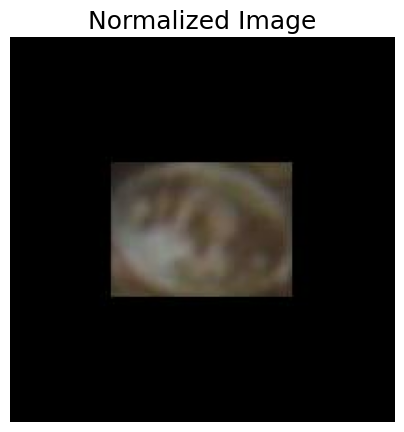

In [ ]:
# Call the function to display normalized image
show_normalized_image(image_path)

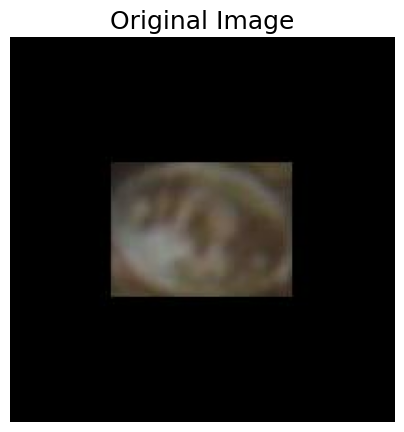

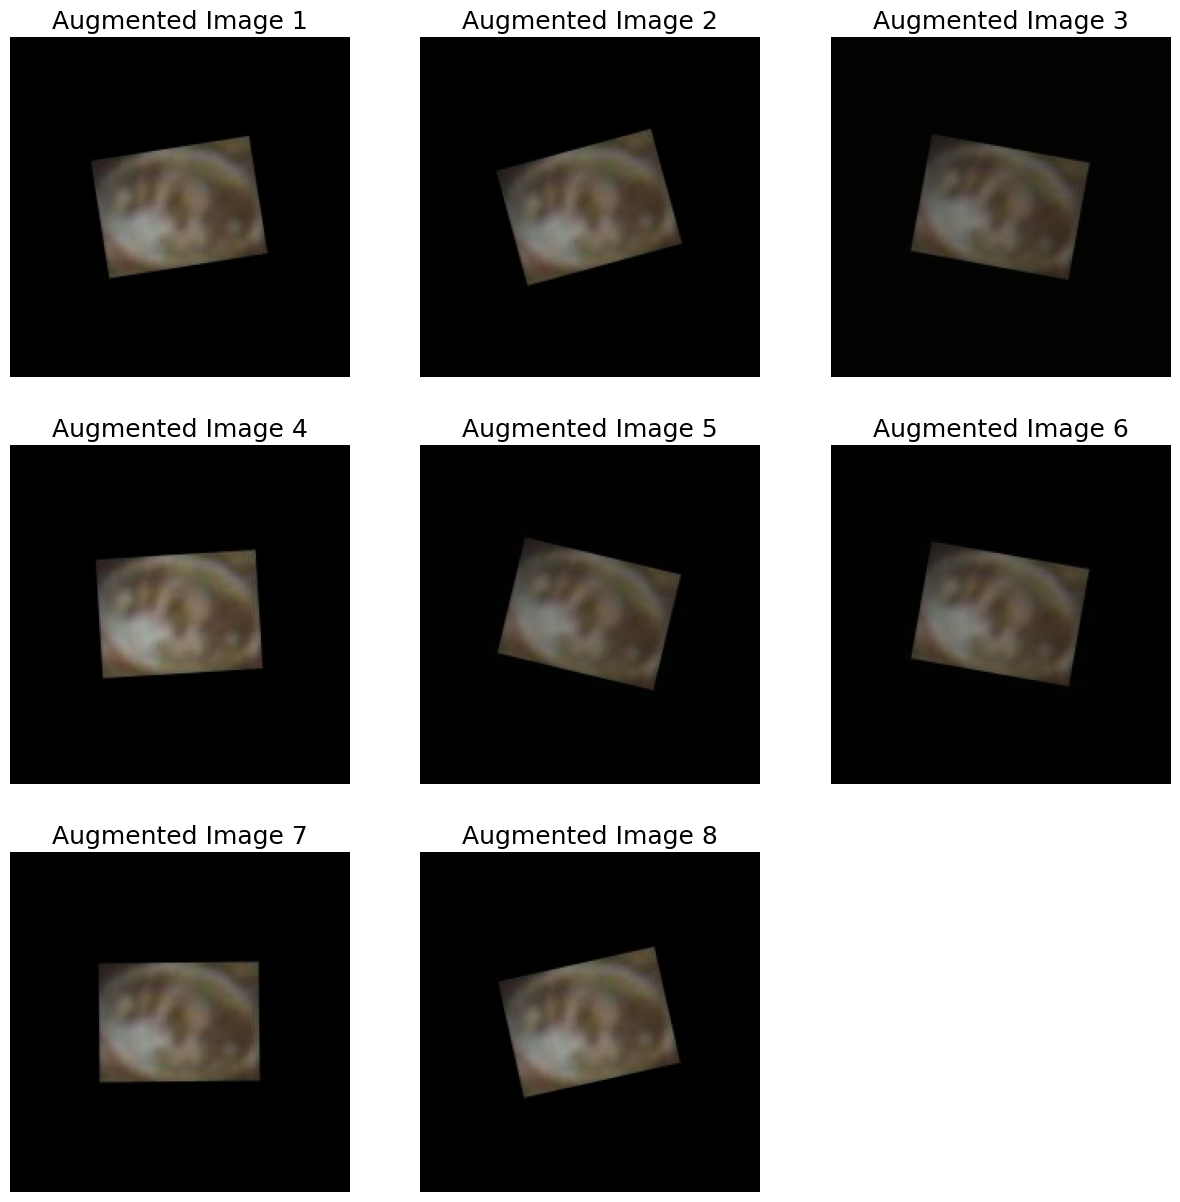

In [ ]:
# Demonstrate the augmentation layers (keras)
show_augmentation_layers(image_path, data_augmentation_layers)

### Train, test, val split and classes

In [ ]:
# Define the paths
all_images_path = "/content/drive/MyDrive/data/species_53/Binary_Classification/"+"/all_standardised_cropped_segmentations/"

# Separate the data based on the source
train_val_df = df
test_df = test_df

# Split train/validation data
X_train_val = all_images_path + train_val_df['image_name']
y_train_val = train_val_df['binary_classification']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
X_test = all_images_path + test_df['image_name']
y_test = test_df['binary_classification'].values

# Preview the split
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

Training samples: 680, Validation samples: 170, Test samples: 255


In [ ]:
# Concatenate train/val and test labels to define classes
all_labels = all_df['binary_classification']
classes_to_predict, num_classes = define_classes(all_labels)

In [ ]:
# Find class weights
class_weight = find_binary_class_weights(y_train)

Weight for class 0: 0.97
Weight for class 1: 1.03


In [ ]:
def augment_batch(image, label):
    """Apply the imgaug augmentation to the batch"""
    def imgaug_augment_image(image):
        return seq.augment(image=image.numpy())
    image = tf.cast(image, tf.uint8)
    image = tf.py_function(imgaug_augment_image, [image], tf.uint8)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Build dataset, lists for training history and apply augmentation

In [ ]:
# create list to record model training history
HISTORY_HISTORY_ACCURACY = []
HISTORY_HISTORY_VALACCURACY = []
HISTORY_HISTORY_LOSS = []
HISTORY_HISTORY_VALLOSS = []

In [ ]:
#build the dataset
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [ ]:
# training_data = training_data.map(augment_batch) # apply the imgaug augmentation to the train set only
# Create the batches
training_data_batches = training_data.shuffle(buffer_size=1105).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1105).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_data_batches = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## Model building and training

In [ ]:
from tensorflow.keras.applications import EfficientNetB1

In [ ]:
def create_model_enb1(input_shape, num_classes, dropout_rate, data_augmentation_layers):
    enb1 = EfficientNetB1(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation_layers(inputs) if data_augmentation_layers else inputs

    x = enb1(x, training=False)

    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
# Create the model
model = create_model_enb1(input_shape=input_shape,
                          num_classes=num_classes,
                          dropout_rate=dropout_rate,
                          data_augmentation_layers=data_augmentation_layers)

decay_steps = int(round(len(X_train) / batch_size)) * epochs
cosine_decay = CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, alpha=alpha)
optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_decay)
callbacks = [ModelCheckpoint(filepath=this_model_path, monitor='val_loss', save_best_only=True)]
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Display the model summary
model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 206, 206, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 206, 206, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 1280)                │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,577,801 (25.09 MB)

 Trainable params: 6,515,746 (24.86 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [ ]:
# def create_model_enb1(input_shape, num_classes, dropout_rate, data_augmentation_layers):
#     enb1 = EfficientNetB1(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape,
#         pooling='avg'
#     )

#     # Add data augmentation layers if provided
#     inputs = tf.keras.Input(shape=input_shape)
#     x = data_augmentation_layers(inputs) if data_augmentation_layers else inputs

#     # Add EfficientNetB1 model
#     x = enb1(x, training=False)

#     # Add dropout and final dense layers
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
#     outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

#     model = tf.keras.Model(inputs, outputs)
#     return model

In [ ]:
# # Create the model
# model = create_model_enb1(input_shape=input_shape,
#                           num_classes=num_classes,
#                           dropout_rate=dropout_rate,
#                           data_augmentation_layers=data_augmentation_layers)

# # Set the optimizer and callback
# decay_steps = int(round(len(X_train) / batch_size)) * epochs
# cosine_decay = CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, alpha=alpha)
# callbacks = [ModelCheckpoint(filepath=this_model_path, monitor='val_loss', save_best_only=True)]
# model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay), metrics=["accuracy"])

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 206, 206, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 206, 206, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 1280)                │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,577,801 (25.09 MB)

 Trainable params: 6,515,746 (24.86 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [ ]:
# Train the model
history = model.fit(training_data_batches,
                        epochs = epochs,
                        validation_data=validation_data_batches,
                        class_weight=class_weight,
                        callbacks=callbacks)

# save the whole model (structure and weight)
model.save(this_model_path)

# record the training and validation histroy
HISTORY_HISTORY_ACCURACY.append(history.history['accuracy'])
HISTORY_HISTORY_VALACCURACY.append(history.history['val_accuracy'])
HISTORY_HISTORY_LOSS.append(history.history['loss'])
HISTORY_HISTORY_VALLOSS.append(history.history['val_loss'])

Epoch 1/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 450s 12s/step - accuracy: 0.6940 - loss: 0.6057 - val_accuracy: 0.5765 - val_loss: 0.6647
Epoch 2/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 272s 11s/step - accuracy: 0.7948 - loss: 0.4272 - val_accuracy: 0.5765 - val_loss: 0.6519
Epoch 3/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 324s 11s/step - accuracy: 0.8283 - loss: 0.3636 - val_accuracy: 0.6706 - val_loss: 0.5719
Epoch 4/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - accuracy: 0.8612 - loss: 0.3335 - val_accuracy: 0.7647 - val_loss: 0.5244
Epoch 5/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 324s 11s/step - accuracy: 0.8679 - loss: 0.3015 - val_accuracy: 0.7882 - val_loss: 0.4802
Epoch 6/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 267s 11s/step - accuracy: 0.8940 - loss: 0.2900 - val_accuracy: 0.7882 - val_loss: 0.4485
Epoch 7/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 316s 11s/step - accuracy: 0.8947 - loss: 0.2614 - val_accuracy: 0.7882 - val_loss: 0.4576


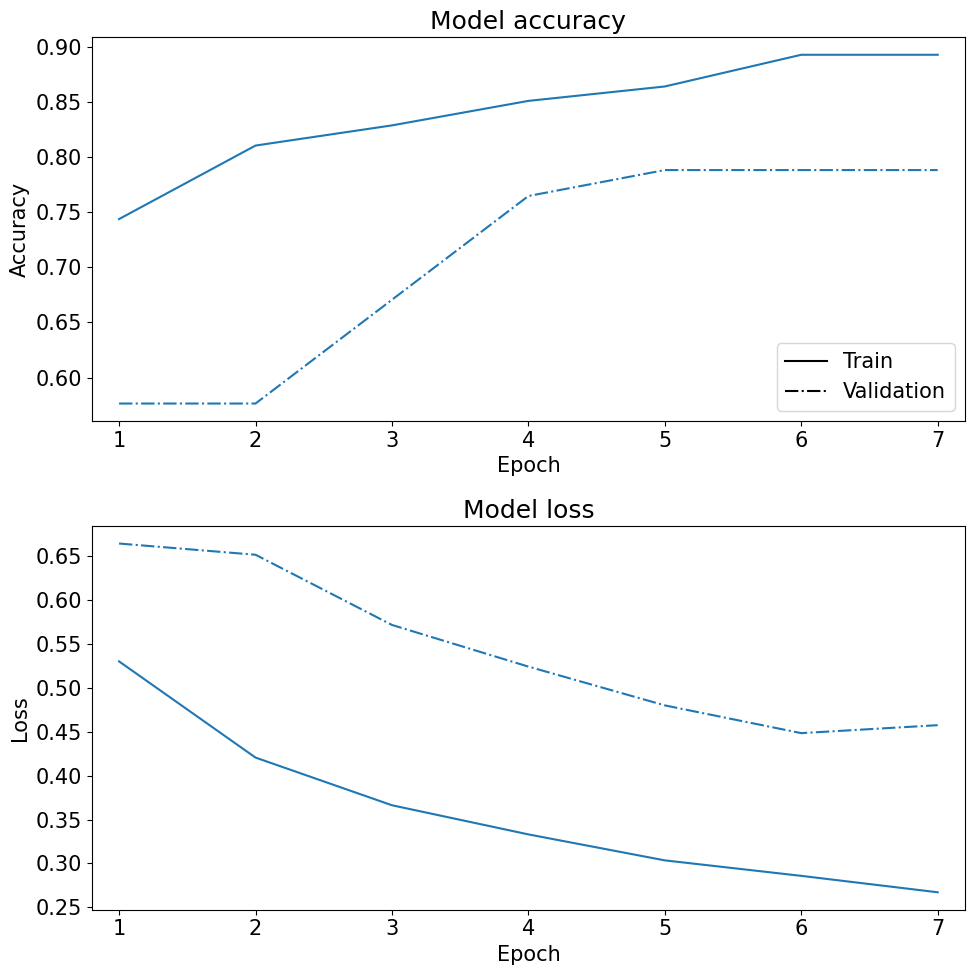

In [ ]:
def plot_learning_curve(HISTORY_HISTORY_ACCURACY: list,
                        HISTORY_HISTORY_VALACCURACY: list,
                        HISTORY_HISTORY_LOSS: list,
                        HISTORY_HISTORY_VALLOSS: list,
                        epochs) -> None:
    """
    Plot the learning curves: accuracy and loss.
    """
    plt.figure(figsize=(10,10), linewidth=1.5)
    plt.subplot(2,1,1)
    plt.plot([-1,-1],[max(max(HISTORY_HISTORY_ACCURACY)),max(max(HISTORY_HISTORY_ACCURACY))],color="black",linestyle="-")
    plt.plot([-1,-1],[max(max(HISTORY_HISTORY_ACCURACY)),max(max(HISTORY_HISTORY_ACCURACY))],color="black",linestyle="-.")
    plt.legend(['Train','Validation'], loc='lower right')
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_ACCURACY).T)
    plt.gca().set_prop_cycle(None)
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_VALACCURACY).T,"-.")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xlim([0.8, epochs+0.2])
    # summarize history for loss
    plt.subplot(2,1,2)
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_LOSS).T)
    plt.gca().set_prop_cycle(None)
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_VALLOSS).T,"-.")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([0.8, epochs+0.2])
    plt.tight_layout()

plot_learning_curve(HISTORY_HISTORY_ACCURACY,HISTORY_HISTORY_VALACCURACY,HISTORY_HISTORY_LOSS,HISTORY_HISTORY_VALLOSS,epochs)

## Model Performance Evaluation

In [ ]:
# LOAD MODEL to evaluate the performance of the model
model = load_model(this_model_path)

In [ ]:
# Classification on the test set
test_data_batches = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_predictions = model.predict(test_data_batches,verbose=1)
# Get most likely class
predicted_classes = np.argmax(test_predictions, axis=1)

#Get ground-truth classes and class-labels
true_classes = np.concatenate([y for x, y in test_data_batches], axis=0)
class_labels = ['Non_Nannofossil','Nannofossil'] # label 0 = Non nannofossil; 1 = Nannofossil

8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step


                 precision    recall  f1-score   support

Non_Nannofossil       0.54      0.86      0.66       145
    Nannofossil       0.17      0.04      0.06       110

       accuracy                           0.51       255
      macro avg       0.35      0.45      0.36       255
   weighted avg       0.38      0.51      0.40       255

AUC-ROC score =  0.44639498432601876


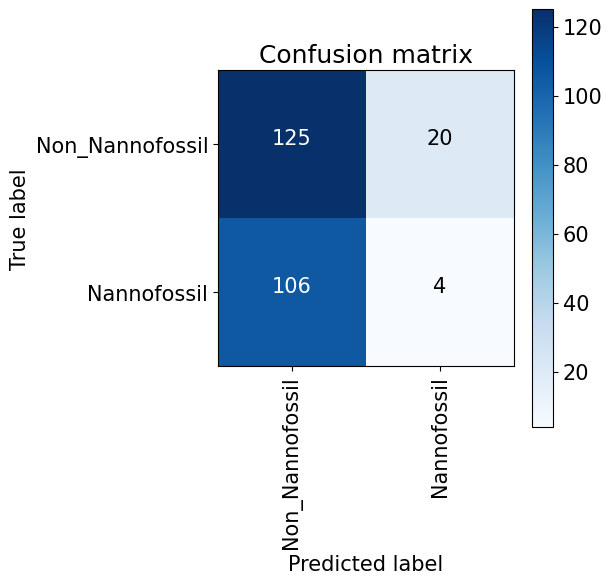

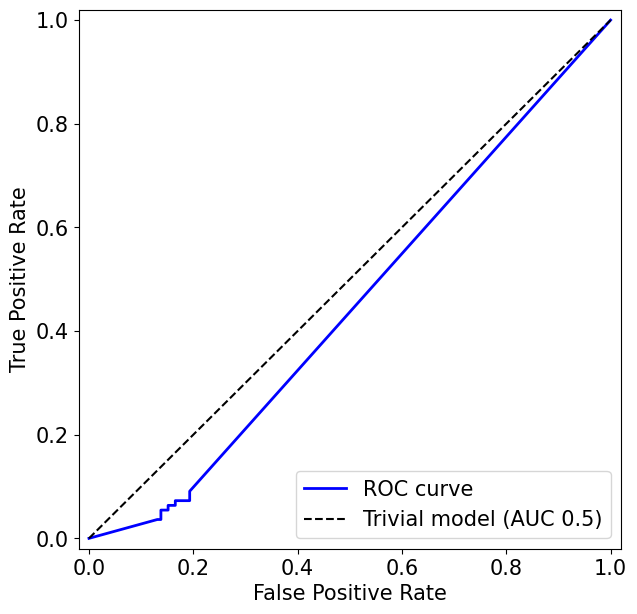

In [ ]:
# Analysis on the classification performance on the test set
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

#plot confusion matrix
cm = confusion_matrix(true_classes,predicted_classes)
plot_confusion_matrix(cm, class_labels, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues)

#plot the ROC curve
plot_roc_curve(true_classes, test_predictions)

(array([231.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  24.]),
 array([0.        , 0.09999999, 0.19999999, 0.29999998, 0.39999998,
        0.49999997, 0.59999996, 0.69999993, 0.79999995, 0.89999998,
        0.99999994]),
 <BarContainer object of 10 artists>)

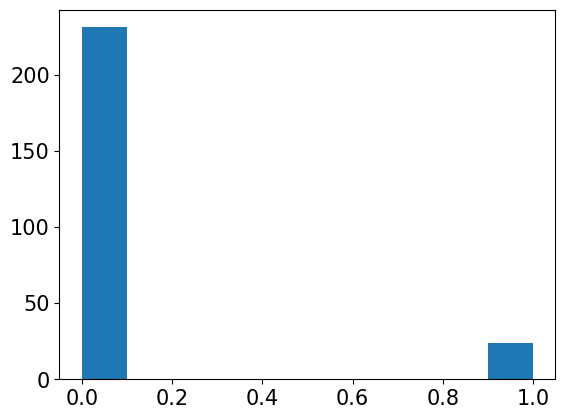

In [ ]:
plt.hist(test_predictions[:,1])

## Save results to dataframe

In [ ]:
image_names_test = [os.path.basename(path) for path in X_test]

In [ ]:
# Save groundtruth and predicted labels in dataframe
epoch_100_dataframe = pd.DataFrame()
epoch_100_dataframe['image_name'] = image_names_test
epoch_100_dataframe['groundtruth_labels'] = true_classes
epoch_100_dataframe['Predictions'] = test_predictions[:,1]

In [ ]:
results_directory = "/content/drive/MyDrive/data/species_53/Binary_Classification/model_save"
results_path = os.path.join(results_directory, "recent_epoch_100_dataframe.csv")

In [ ]:
# Save as CSV
epoch_100_dataframe.to_csv(results_path, index=False)
print(f"DataFrame saved to {results_path}")

DataFrame saved to /content/drive/MyDrive/data/species_53/Binary_Classification/model_save/recent_epoch_100_dataframe.csv


## Model performance on individual examples

In [ ]:
# Prediction and expected output on few random samples (hold out test set)
for x in random.sample(range(0, len(test_data)), 5): # test the prediction on 5 random images
    test_image(x,model,X_test,y_test)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

1/1 [==============================] - 0s 30ms/step
Image:PM_NF_5404_02_1_4.jpeg
expected output:  Others     = 0
predicted output: Others     = 0


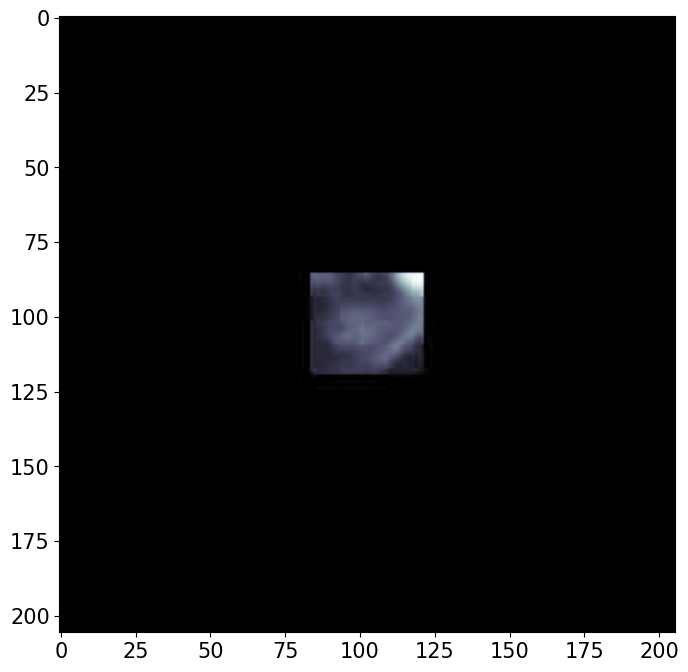

---------------------------------------------
1/1 [==============================] - 0s 29ms/step
Image:PM_NF_5065_14_32_4.jpeg
expected output:  Others     = 0
predicted output: Others     = 0


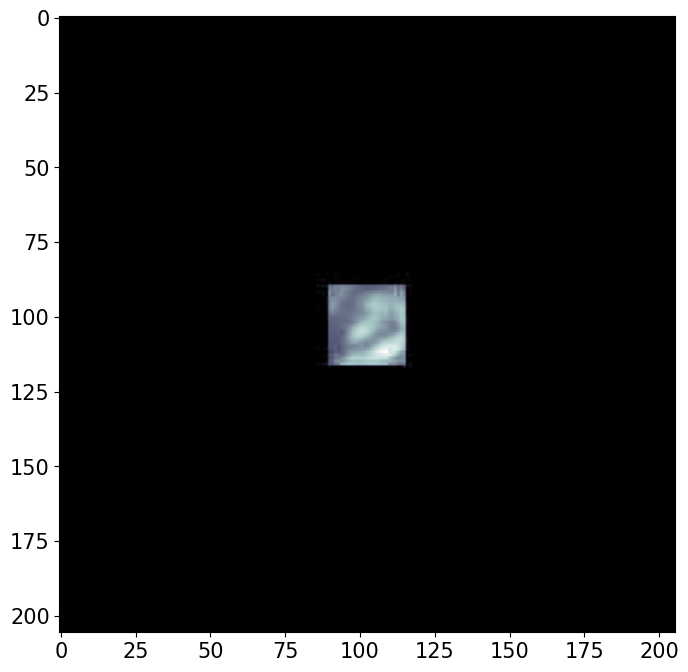

---------------------------------------------
1/1 [==============================] - 0s 28ms/step
Image:PM_NF_5311_56_30_1.jpeg
expected output:  Whole lung = 1
predicted output: Whole lung = 1


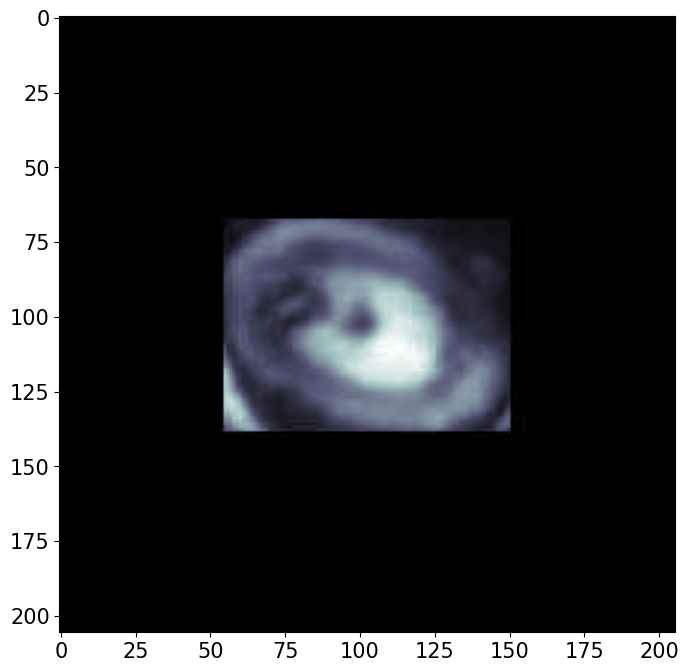

---------------------------------------------


In [ ]:
# Display 3 correctly predicted images
display_right_prediction(3, model, X_test,y_test)

1/1 [==============================] - 0s 39ms/step
Image:PM_NF_5311_74_13_2.jpeg
expected output:  Others     = 0
predicted output: Whole lung = 1


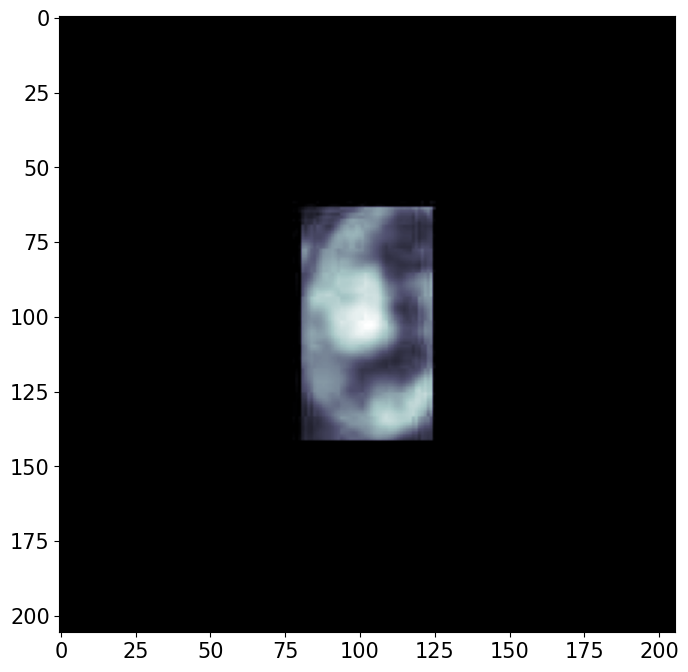

---------------------------------------------
1/1 [==============================] - 0s 30ms/step
Image:PM_NF_5362_26_19_2.jpeg
expected output:  Whole lung = 1
predicted output: Others     = 0


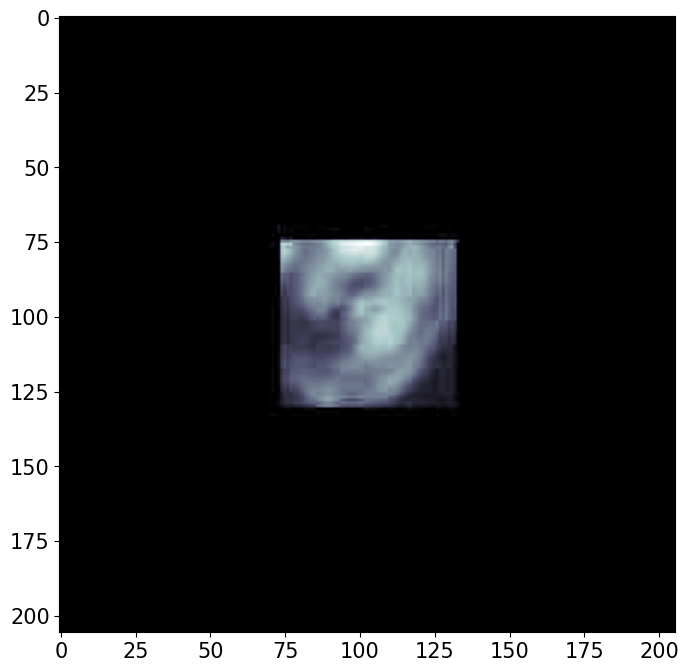

---------------------------------------------
1/1 [==============================] - 0s 62ms/step
Image:PM_NF_5065_19_10_6.jpeg
expected output:  Whole lung = 1
predicted output: Others     = 0


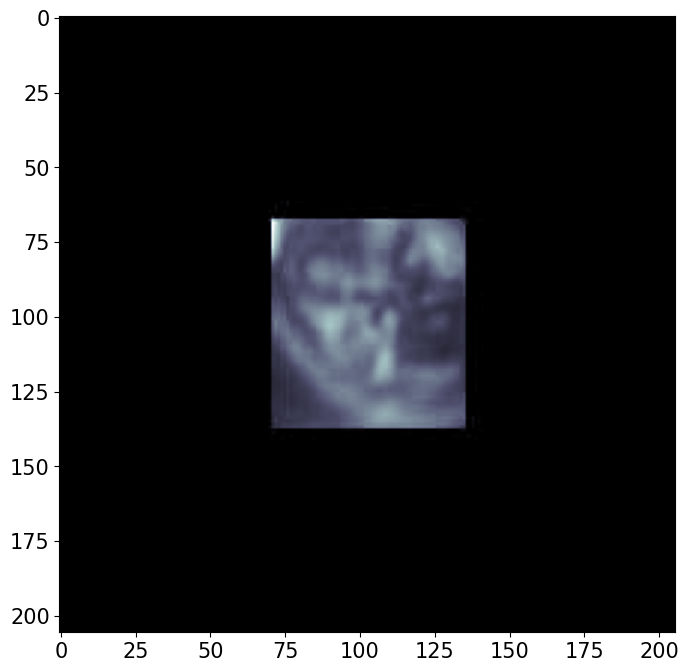

---------------------------------------------


In [ ]:
# Display 3 wrongly predicted images
display_wrong_prediction(3, model, X_test,y_test)